In [211]:
from collections import Counter, defaultdict

## A basic n-gram generator
Using the tokenizer written in Assignment 3

In [199]:
def new_reg_tokenize(sent):
    fin = re.findall(r'[\U00010000-\U0010ffff]'\
                     r'|[A-Z0-9a-z]+[A-Z0-9a-z._%+-]*@[A-Z0-9a-z]+(?:\.[A-Z0-9a-z]+)+'\
                     r'|(?<= )[$€£¥₹]?[0-9]+(?:[,.][0-9]+)*[$€£¥₹]?'\
                     r'|(?:(?:https?:\/\/(?:www.)?)|www.)[A-Z0-9a-z_-]+(?:\.[A-Z0-9a-z_\/-]+)+'\
                     r'|(?:(?<=[^A-Za-z0-9])|^)@[A-Z0-9a-z._+]+[A-Za-z0-9_]'\
                     r'|#[A-Za-z0-9]+(?:[\._-][A-Za-z0-9]+)*'\
                     r'|\.{3,}'\
                     r'|[!"#$%\&\'()*+,\-.:;<=>?@\[\\\/\]\^_`{\|}~]'\
                     r'|[A-Z]\.'\
                     r'|\w+', sent)
    return fin

In [200]:
import re
# from nltk.tokenize import word_tokenize

def ngrams(sentence, n):
    '''
    This currently does not accomodate for numbers with punctuation.
    '''
#     sentence = sentence.lower()
    
    tokens = new_reg_tokenize(sentence)
    
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [ngram for ngram in ngrams]

# Creating the Model

Outputs we get from this:
1. `cn` stores the number of n-grams for each n, n=1-n
2. `model` stores the counts of each n-gram
3. `incv` stores the various contexts of the n'th gram, with counts
4. `invc` stores the count of number of contexts for the n'th gram


In [201]:
cn = defaultdict(lambda: 0)
def create_model(file="../corpus3.txt", n=3):
    '''
    Takes a file to train on, an 'n'
    Returns predictive n-gram model
    '''
    global cn
    # Create a placeholder for model
    model = defaultdict(lambda: defaultdict(lambda: 0))
    incv = defaultdict(lambda: defaultdict(lambda: 0))
    invc = defaultdict(lambda: defaultdict(lambda: 0))

    with open(file, 'r') as f:
        linet = f.read()
    
#         for line in f:
        for i in range(1, n+1):
            for ngram in ngrams(linet, n=i):
                cn[i] += 1
                wprec = tuple(ngram[:i-1])
                waft = ngram[i-1]
                model[wprec][waft] += 1
                if i >= 2:
                    incv[waft][wprec] += 1
                    if incv[waft][wprec] == 1:
                        invc[waft][len(wprec)] += 1
        f.close()    
            
    return model, incv, invc

In [202]:
%%time
model, incv, invc = create_model(n=3)

CPU times: user 809 ms, sys: 16.1 ms, total: 825 ms
Wall time: 835 ms


In [203]:
model[('this', 'is', )]

defaultdict(<function __main__.create_model.<locals>.<lambda>.<locals>.<lambda>()>,
            {'more': 1,
             'not': 2,
             'known': 1,
             'the': 2,
             'our': 1,
             'a': 1,
             'my': 1,
             '!': 1})

In [204]:
invc['more']

defaultdict(<function __main__.create_model.<locals>.<lambda>.<locals>.<lambda>()>,
            {1: 41, 2: 63})

In [205]:
invc['is']

defaultdict(<function __main__.create_model.<locals>.<lambda>.<locals>.<lambda>()>,
            {1: 504, 2: 793})

# Kneysey-Ney Smoothing

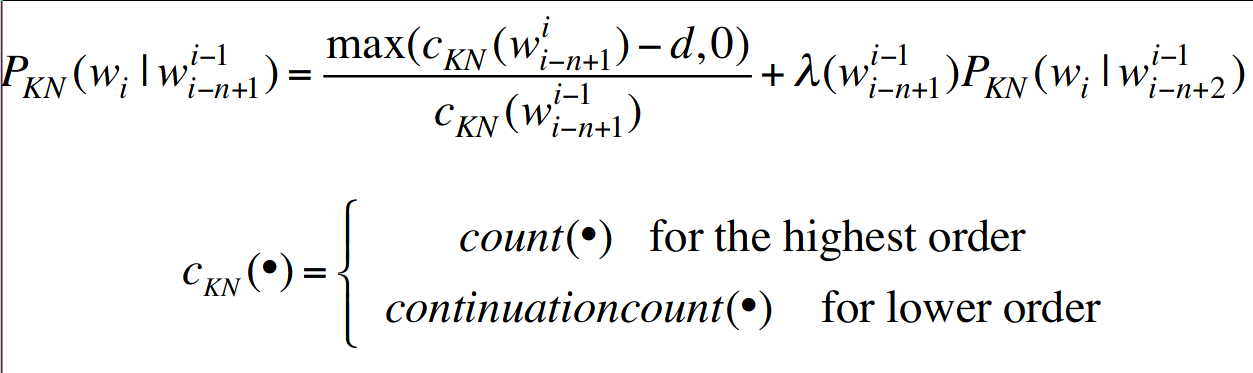

In [206]:
def count_cn(seq, pred, first):
#     print(seq, pred, first)
    if first:
        return model[seq][pred]
    else:
        return invc[pred][len(seq)+1]

def lamda(seq, pred, d):
#     print(seq, pred, d)
    return d*len(model[seq])/(cn[len(seq)+1])

def kneyser(seq, pred, d, first):
#     print(seq, pred)
    if len(seq) == 1:
        return (max(count_cn(seq, pred, first) - d, 0)/count_cn(seq[:-1], seq[-1], first))+lamda(seq, pred, d)*(count_cn(seq, pred, first)/len(model[()]))
    else:
        return (max(count_cn(seq, pred, first) - d, 0)/count_cn(seq[:-1], seq[-1], first))+lamda(seq, pred, d)*kneyser(seq[1:], pred, d, False)

def kneyser_ney():
    smooth = defaultdict(lambda: defaultdict(lambda: 0))
    for seq in model:
        if len(seq) == 0:
            continue
        for pred in model[seq]:
            smooth[seq][pred] = kneyser(seq, pred, 0.75, True)1
#             print(smooth[seq][pred])
            
    return smooth

smoothed = kneyser_ney()

# Calculating Perplexity


In [223]:
import math

def perplexity(file='../corpus3.txt', n=2):
    text = ''
    with open(file, 'r') as f:
        text = f.read()
    
    summed = 0
    
    seqs = ngrams(text, n=n)
    for seq in seqs:
        prob = smoothed[seq[:-1]][seq[-1]]
        summed += prob*math.log(prob, 2)

    summed = (summed*-1)/len(seqs)
    return pow(2, summed)

print(perplexity(n=3))

1.2715545205935708


In [222]:
with open('../corpus3.txt', 'r') as f:
    text = f.read()
    for seq in ngrams(text, n=3):
#         print(seq[:-1])
#         print(seq[-1])
#         print(smoothed[seq[:-1]][seq[-1]])

0.44022347316078797
0.0014162858479977055
0.041996425870602115
0.2503228344851602
0.025023950784012833
0.0420256791942742
0.25000016544844067
0.2672059826669067
0.1250045103643566
0.0010703630358055453
0.12503191217824464
0.25000341916210417
0.253100799955643
0.1250307129359633
0.011257672440485462
0.0089624781474524
0.2500415998041599
0.25000368217539404
0.25198957234647096
0.05000028222787627
0.11430410315987945
0.2500043447037986
0.012766388339824703
0.029657865470909504
0.5626140760460704
0.4500893450935751
0.014080317286335487
0.020841056509530106
0.08403953489053508
0.05006571263510551
0.04598079470365279
0.022896521885831203
0.0873039511843443
0.07259597748504541
0.0024363637220884736
0.2500050147717204
0.7573739927500678
0.0500039862437354
0.09569043709959196
0.05438643316732371
0.13911455383883328
0.41931374523400733
0.008067570760313605
0.16201723753575714
0.13890455624562775
0.7507387290358017
0.5312536726772024
0.10912265405581088
0.1136866194924591
0.0014066976699651976
0.

0.2500011397206665
0.2619374339114219
0.250030964650143
0.0017352518535399882
0.019879107535257543
0.2500100629120612
0.042645866929835616
0.08335468121343231
0.0030509897030610317
0.04282110083347794
0.08333620117273229
0.25074608977069796
0.13889003658503485
0.6050517845632188
0.025001831901017794
0.005969027852098447
0.25043195413927166
0.25000040417023944
0.2586029915636712
0.12500142516464877
0.16926845412332103
0.006961480882404069
0.254692541397063
0.0227276277578567
0.11397486067338215
0.12506317309166937
0.252457998482302
0.03126353109306981
0.040284511344641546
0.018475313576312304
0.7085030896379653
0.14509821858394883
0.7674848356960982
0.015637909715326172
0.01436894423393929
0.1250014892739228
0.25119374354180557
0.2500183176614302
0.009647450576562454
0.14776281123421778
0.4773722157630604
0.0015995751158950184
0.25246407600883775
0.2500126444361675
0.06320647750177599
0.08335762870698593
0.007219618730030394
0.09631402085071594
0.2520278434846121
0.05000829421628732
0.0

0.127935022944636
0.12500367772401477
0.45375150600917386
0.027777951869970157
0.2559687169633202
0.1250071118301841
0.010074451245003984
0.06376850998822843
0.2500153564679817
0.00224885987968463
0.06332971666475097
0.2503511013013176
0.003258487997780748
0.002758909031520613
0.26720598260113015
0.1250045103643566
0.005019624937134237
0.4177536345633819
0.08333375307902718
0.12549805792626675
0.25006331289364214
0.06251308872851433
0.13294122438845646
0.25000285032929753
0.16926845412332103
0.007069130800195581
0.05000211664424418
0.1251109328099159
0.2551617954644151
0.04168411035391143
0.012993855788133467
0.10664879750878059
0.06251474248752656
0.37979967736749703
0.016743052532416654
0.6280363503737848
0.010881358313516012
0.07759123853052259
0.07815196622024884
0.5192980572530621
0.09783120452574008
0.48049627225076436
0.5416676965816895
0.5853557708830746
0.02272746999196255
0.03636848536313099
0.25155040007271073
0.25000135380033955
0.2607066847312351
0.013895620782371792
0.083

0.2500077751002345
0.25003243027290095
0.2508193346691772
0.01924159204753753
0.2054550953200115
0.005260645370148278
0.019408663405646696
0.06250005301444413
0.25000227944127495
0.3016179474745077
0.2500000149064813
0.06837639965198276
0.25000131869447645
0.053780577436929315
0.05000182748678622
0.2626748189490041
0.12159632122844538
0.05016924870113153
0.12515117600620632
0.017978474257112277
0.09493199543952913
0.008620851714595167
0.2653657135758797
0.2500008227883958
0.012915998072500814
0.25007802704737797
0.41683444734287556
0.023766436710623534
0.14620655134931212
0.09628697384747524
0.005421869954901296
0.010601887835426645
0.2500030977100364
0.2513263816048967
0.022756973087503785
0.017928715276132788
0.6262589764318917
0.006953173427266861
0.043335256754775515
0.3766996598898248
0.20842130404207218
0.008353854086161997
0.06251139720715322
0.2758089738359187
0.25000008151874775
0.2742190073827273
0.06250098604941788
0.03428945904628848
0.25000575286849264
0.003850786578632858

0.072355349231163
0.0033794041912480494
0.25886474708450097
0.25000003239181007
0.2519432236869334
0.2500014302004505
0.2512904494745368
0.007582034162664876
0.7404815096511231
0.003795196499918332
0.25053851800672805
0.25000060664086704
0.054390204069092465
0.12500102055283557
0.6622061802034966
0.060841234907377584
0.7507815639013373
0.1136391709520178
0.2985964208416119
0.25000006264905755
0.625001139720655
0.1557314271909325
0.2500080984578842
0.04221597385351664
0.006415056237011763
0.2510741867227738
0.2500045698942079
0.0657261307902087
0.12505637955445756
0.0025383365264278015
0.25001208103967165
0.2505556576986269
0.2500083650235322
0.035724647500626816
0.2501151123032391
0.4166692808041783
0.025115340176256582
0.2500163441282188
0.25000242650836785
0.2500584106872063
0.2502263556439494
0.25000000427183455
0.2566764834688896
0.2500000542904409
0.2500051287429471
0.2500068383238598
0.26720598260113015
0.12500064685290427
0.0342390174578248
0.08334541440032861
0.2503512239348894

0.09841345530621777
0.011909652723910109
0.00442563827856178
0.08334727300654084
0.25003447655306976
0.2525808983570847
0.09615611013901111
0.017085670508120196
0.12509528066327968
0.25003434886141074
0.12500063123407051
0.2531007999675042
0.25000575286849264
0.003947557543674311
0.250069352092562
0.016706257816157043
0.316470617851011
0.04033952218103672
0.15889465675615086
0.13930627041273724
0.0063107743764996916
0.2500031912185354
0.2586029914321182
0.06250902072871321
0.0040063100170500575
0.25038315344023726
0.25003951026590276
0.0042902960011222055
0.25003484291140754
0.25014447161371706
0.2500000950097586
0.2500051287429471
0.6508089738359186
0.1250019510509626
0.0201795933325517
0.25535929376600885
0.6250002049473143
0.14364437346736786
0.625001753017975
0.1785718193350882
0.22823589508056852
0.2500043447037986
0.10579620127879222
0.007669110722825102
0.12500987757955137
0.26290448698373586
0.12500035936838605
0.008187049012995246
0.25322612223925806
0.050000142103949
0.085423

0.08333928816027561
0.4860454728961693
0.002232391908553628
0.2542146869013268
0.2500048859793926
0.20838120182291395
0.1285598633094457
0.1562612759108915
0.040284511344641546
0.01786795183958193
0.25124495488430093
0.12503320756205424
0.00409867180982939
0.2527376089607892
0.25008487815231595
0.029023541947115438
0.2809707690372276
0.041667071637343074
0.09387973892237032
0.12500325964803718
0.25000963582546226
0.250302351677489
0.2500014265651413
0.08417759529845797
0.08333405233515861
0.1250005698605017
0.2509231737128447
0.25092175287590973
0.011918419261500043
0.11639664674214106
0.01164128618555227
0.32571422547435647
0.0053251921965289245
0.1250014246516725
0.25596871697853874
0.25000095201000483
0.2501114019633971
0.25000000555052354
0.26875752218007726
0.25000020494731434
0.12507469555183975
0.25147480066801825
0.020833482398146842
0.12509687625573732
0.25004630115923543
0.125023344728891
0.2123039511843443
0.04033952218103672
0.04543924782086022
0.12505499490027394
0.0125391

0.2500265193866922
0.6250902234136658
0.5835395156086818
0.001555120602178381
0.08334233113389297
0.2500049387896828
0.2501132122516207
0.25000605231444056
0.25000107973599744
0.26720598260113015
0.1250058145624149
0.007112923949654595
0.06418852393024929
0.08333335278046405
0.2501755169775109
0.2532261221734815
0.08929284010895805
0.013527190664599828
0.0849642735698122
0.2500048288511308
0.2501915767900425
0.12513118013837146
0.007813041620154075
0.25059835333469827
0.25000002561343054
0.3016179474745077
0.2500022551821783
0.029641274802469125
0.011425583581855662
0.2500081408622241
0.6353235897448524
0.06250390210192518
0.08022180899121449
0.12510488170135936
0.5427199705706194
0.00320136765208149
0.2554334760414727
0.006253807569771207
0.0953303367135161
0.2083819498902184
0.4173688692693019
0.0031260350222462375
0.2593787611019927
0.12500081203605978
0.45583659698001217
0.10419628208912088
0.01752199480824705
0.5313928450938304
0.2500816327846701
0.037632349455042444
0.02571422547

0.007599585577172827
0.02287543666915139
0.2501327775383961
0.2500053236175905
0.06250010361208176
0.3016179474745077
0.2500000043887551
0.12662752106621947
0.25008874392471586
0.05000058247214192
0.25041827749106416
0.1250205383171348
0.016703776691164744
0.48942821554492894
0.014710523395197685
0.54978271823888
0.005589582151617016
0.62589321560376
0.020834435404795675
0.1293902041474388
0.3750251279280477
0.0015491640413376993
0.6254205569152502
0.6250009897661732
0.6257608775228447
0.4166668148152726
0.7502154072005025
0.4168767451302043
0.1250007695517865
0.6289706114049097
0.01785715345129864
0.3016179474745077
0.25000029537918206
0.08857430683473758
0.7813034223777438
0.1627553595031867
0.003869008835332564
0.023491455549871133
0.25031659834713116
0.2031281609909911
0.04186937416944479
0.25000084665119204
0.25232559999638515
0.2500153564679817
0.020678389480063897
0.5275358537639613
0.037585223831269894
0.07580897830872363
0.12500180380279471
0.005425544425506663
0.6251988812522

0.12514702396532024
0.250090313098452
0.0833449333466621
0.2500091684380074
0.4639919394538491
0.007812520305465255
0.25059493417050305
0.2500005544598706
0.2519853933555797
0.1250100756779303
0.13261993380008433
0.2758517614626489
0.17801061179477534
0.10579620127879222
0.18909108216850185
0.008963646298924145
0.25008222272189395
0.2500000325644573
0.25161612385778837
0.25001036907765767
0.4178670900997071
0.10306282817694958
0.0014991277820634251
0.6258508828981529
0.6250364844420795
0.017859921709088403
0.12501595608954053
0.2586029915636712
0.12500011395477292
0.01512757899944123
0.25000937103688575
0.2500193752525276
0.2500028157817085
0.2500296327372136
0.12502700261700056
0.25286766420536533
0.12500198611005017
0.06465108226858349
0.25050472183981237
0.059546151751078406
0.11363673579561553
0.6316764834688896
0.6250000542904409
0.6254405020331588
0.12500074493138433
0.13524380931174093
0.12500080570085068
0.0417131672736669
0.25010257485883763
0.625097548508317
0.625000238676623

0.25000217117943874
0.012591926578040414
0.2500680910391557
0.3125722367201667
0.07812672835695443
0.1508089744936841
0.06250902072871321
0.07283820764520699
0.005248837173280524
0.12504851954694068
0.25064681161090524
0.017871987397788947
0.4186909031872088
0.005954467146428031
0.2104556327069769
0.08333350978474778
0.2629044870495124
0.12500198611005017
0.0805703215490306
0.048103421834422955
0.0833338675834436
0.2537348645195374
0.12500000854366913
0.2527376089607892
0.25000034037993113
0.25000775010058585
0.2500041029944483
0.2551219045775241
0.2500062819820119
0.0021190295268277057
0.1286117748476138
0.08340779061002068
0.0014398884566061278
0.25001424651347226
0.2523462716522914
0.02272865410627675
0.006265956094942529
0.2593023998076232
0.2500153564679817
0.18105031303017083
0.05261826274511534
0.06265545856879458
0.25001897010135554
0.09649776056194229
0.013888941628454126
0.26875752218007726
0.25000003481055505
0.06269147306723728
0.2603235896790759
0.04167138390511655
0.00735

0.12501367664785895
0.2672059826669067
0.2500000043887551
0.13547175319058402
0.2500000277393045
0.6343023998076233
0.12505098582469112
0.004100275236265427
0.2524078498062849
0.1250008052940649
0.625215913776614
0.625001894833587
0.250000222386744
0.6766179474745078
0.12500031729748093
0.06773754829148898
0.06250555456625663
0.250679066322178
0.6250351330685517
0.007543026883342638
0.1403657141047175
0.12500002442090563
0.25465119992160334
0.2500010068315838
0.07416815212495549
0.4166681591444391
0.31557314353389526
0.1250039698846282
0.07513646144407639
0.9318257684026233
0.015919249848982932
0.08335062465993215
0.02500113972481387
0.2508411138272593
0.25000002999362403
0.2501025748569905
0.2546925411997334
0.041667744771824784
0.006114276884852746
0.250193752507641
0.25096035723437443
0.25000011963644525
0.1279381998485055
0.06250069513318392
0.12542093682647232
0.2500141040863815
0.2500002035219828
0.2508810040527952
0.25000752379058755
0.06250013025782926
0.3016179474745077
0.2500

0.06250149420970962
0.03130185729687342
0.25148904503567887
0.25000094752901353
0.12507066268171987
0.6251191010818491
0.07795718637428306
0.05000130254093172
0.25361177470021484
0.2501024477404005
0.1389034252949262
0.010558925640711533
0.17892949132961256
0.12500112916239275
0.05332428055937605
0.2500014574106323
0.01772318846426502
0.25049634885933353
0.6250016980446009
0.021640908836229673
0.25000020358762
0.08367448975240302
0.25000269101624784
0.25007258224043366
0.2506002117165202
0.14223826661890696
0.0003244839039661523
0.2566764834688896
0.2500039462550725
0.02500753705009175
0.25469254100240374
0.05001162912482985
0.011087190376211111
0.3231333320070857
0.020833858044521897
0.08490918714580271
0.25003513306855174
0.0008664372551348823
0.5531373224357032
0.0357176049779871
0.4527890971570856
0.05250058472970786
0.006541235443854414
0.8089967567853821
0.1390061958914516
0.016052447554765946
0.01799745452610669
0.050002494099492985
0.0833337607297203
0.2511420000744059
0.250029

0.02777887530837453
0.25088518303411383
0.25032670271043606
0.16936780616700034
0.002625572989149247
0.12646909992425276
0.250000173783296
0.12636880451361393
0.2500049200249944
0.2500004004460087
0.25001652594962404
0.25737399281584433
0.06251737881519448
0.029300633154009915
0.008793832511733376
0.2500001199740083
0.25397914467772337
0.25000339034887264
0.08625818781810807
0.008937130362080785
0.062132569826002654
0.031373158992234376
0.001669776280430698
0.2500011397206549
0.2566764834688896
0.25003436371255805
0.0015139784403838835
0.41629435976872814
0.31251303411139586
0.10579620127879222
0.2828343999578009
0.12500062643232235
0.08412358738450408
0.25002525883305743
0.021093951914568955
0.18750039137228225
0.5016179478033904
0.08333360944275547
0.07486288495953256
0.12506734717396084
0.12500485621122198
0.12807314310299034
0.08335762870698593
0.0011607350478832295
0.25003020259739006
0.2503242067273338
0.2500000079721771
0.2508411138272593
0.25000158962401653
0.2564522440180803
0

0.7171187891228532
0.00927629373993156
0.4323721523479471
0.023497607049737832
0.6074844761644939
0.12500744630255953
0.08752398307264722
0.6250062819820119
0.0014066976699651976
0.2566764834688896
0.25000055540176686
0.25031123894732005
0.25003513306855174
0.0008664372551348823
0.2506069531270062
0.2500000208830192
0.2500056986031816
0.12509573653333983
0.25198957236168945
0.06250031609793706
0.12709435069957176
0.25000000555052354
0.2516617126831136
0.2500008274830415
0.7501510648061883
0.08351548872240644
0.014711718538070797
0.5754044880361606
0.03125780420385037
0.03233815845307428
0.035872114783243245
0.12515629558484823
0.1786167269877349
0.027784726587193352
0.1255482056294602
0.08401958816049945
0.010417467309432804
0.6508089738359186
0.12500000176569262
0.26875752218007726
0.25000060708874544
0.06250037990785307
0.3016179474745077
0.25000002191829884
0.7150098168448
0.4501030911376742
0.013547625371087797
0.08929783678465415
0.6279549157249764
0.6250001360295425
0.12204679546

0.3016179474745077
0.25000290728120744
0.011087190376211111
0.035877791936944875
0.25009142053360106
0.2500003941423448
0.25737399301317393
0.6250043447037986
0.0052587312546312215
0.12622928443101125
0.12500964442918475
0.06254174579289538
0.12500435406509233
0.2500382141782486
0.2500000555965001
0.3016179474745077
0.2500009755254813
0.00908170026253714
0.125008433937786
0.631452243623421
0.03125000706277052
0.2507134651163487
0.2500795225394897
0.00781534553101863
0.25076087752284465
0.250000502040337
0.2511154067069647
0.08333487200009908
0.2546925412655099
0.0625000236839915
0.08615756106950699
0.2500285582602512
0.12500622033026557
0.12930149798534982
0.009626130353113225
0.02619182969630029
0.416713775139889
0.47736813831316804
0.8750109524640093
0.03831950095017387
0.25001252833111004
0.04715783815051552
0.20833504188278082
0.1786986214240357
0.7500235542366112
0.11382295246151725
0.31251897418810315
0.12604208609435527
0.09615598067566074
0.5728235907972771
0.2500063133097815
0

0.005671332322278959
0.2629044875099482
0.02272746999196255
0.3188493837201123
0.08340697045598144
0.004098731157597476
0.252509664834163
0.25009379012113997
0.00862253050148842
0.2518604800421805
0.25000575286849264
0.0038878477992870322
0.1259331316777899
0.08333374142196104
0.1250009117766215
0.3016179474745077
0.2500043447037986
0.04620045811781446
0.017167195519525745
0.42273936820355473
0.03571640245128279
0.01726860212997886
0.12522110580428825
0.2504429715967631
0.250007115960033
0.027486863593966612
0.06250032334098715
0.2559687169633202
0.12501418602319558
0.005322600412935811
0.26720598260113015
0.12500198611005017
0.27014696941573574
0.045357320508857324
0.2373007763215034
0.020835025319297398
0.06352574861883656
0.25000010361126856
0.25161612385778837
0.2500008398104602
0.2508299699387441
0.25000002134951893
0.25001481636830475
0.26290448711528897
0.2500043447037986
0.04528613555953421
0.003378377642327075
0.2502105853358781
0.08336257498865192
0.04166786156922539
0.255968

0.009731885234857865
0.050010661924059084
0.25005385180263495
0.12523225683501243
0.08333335464319097
0.3016179474745077
0.2500022551821783
0.00813004484382164
0.20835384830627188
0.12500151962760184
0.3016179474745077
0.25000007450693024
0.02583995412631987
0.2500002057561596
0.6336029915636713
0.08334636744472919
0.016052447554765946
0.01187867824742816
0.812826702710436
0.16936780616700034
0.05117098101804746
0.010210360069456168
0.1250014649671722
0.031829153547575914
0.25004432492223644
0.010869694864929506
0.3016179474745077
0.2500001621546492
0.018869948615483023
0.12500195844821713
0.08333760728646886
0.2758089738359187
0.2500022551821783
0.0010703630358055453
0.2523255999726628
0.08333334263495475
0.2542967467869123
0.25000001065492883
0.2500296327364701
0.25017836628252876
0.2501755172975297
0.008953227914011777
0.6252464078902088
0.00835947948822741
0.1250039510326384
0.25002108483203456
0.2509849719648431
0.08333407176221484
0.05000103611059454
0.3016179474745077
0.25000099

0.4937816868646224
0.03127606822279171
0.09358938669719172
0.031212674961142745
0.4520841709215769
0.17309414953219937
0.04469603779388927
0.4649810525332962
0.0192506471803426
0.12991599709615712
0.03125003072128552
0.12688281848836608
0.2501328919712668
0.05000831796935741
0.08340008148923676
0.2758517614626489
0.004807717910235457
0.2542146869013268
0.2500148014058241
0.013919861539787826
0.12501848880621433
0.2502098714584902
0.08333667607148743
0.12500629560432663
0.25737399281584433
0.06250390210192518
0.0036095022128429417
0.25074697303536764
0.05000076850544984
0.2551617952670855
0.05000012712103814
0.19552021425798727
0.6250164281587763
0.002215100076847992
0.12500971989980608
0.25066319101550766
0.06250019191902932
0.25248990971144525
0.25000789416200636
0.022730166072429305
0.25192071433164276
0.2500005102764178
0.0367897263373536
0.25060508281827554
0.22500089716356514
0.08373736431794206
0.12500030850333801
0.250012916834058
0.2603235896790759
0.12500028925021087
0.2381063

0.07813387432650959
0.01977291129544397
0.08333393113306634
0.2526796461418508
0.2500002513482487
0.45862876918196127
0.03571439005965517
0.2500059265474706
0.2500119670669114
0.25000797804484
0.2525609523377285
0.2500080984578842
0.002458684322958372
0.25041029960361394
0.12500136034587622
0.7573739928158443
0.0416677754421573
0.0121365637763315
0.25000416713388046
0.12501241029706162
0.2526796461418508
0.027781161248221123
0.1250366990205344
0.2500706627158628
0.25000673152349423
0.25007207760363814
0.25000054336668587
0.6250129928160725
0.5630702402401888
0.953125619552156
0.7414154219135033
0.12042270143210466
0.09600492066890177
0.11998449642178308
0.04316384976731648
0.008943072630789906
0.2629044870495124
0.12500068191199187
0.009639978680382508
0.2502023299663751
0.03814422911839494
0.023145861108718323
0.2500010746028347
0.46152428540225887
0.08336964088614125
0.11100350713970304
0.18909108216850185
0.044651460448807904
0.6258365549532713
0.1250429686193104
0.0108735492805596


0.08333365354715538
0.15941196546536646
0.06251162912482984
0.24522467594532743
0.0015421031900453013
0.260323589810629
0.08333475587491963
0.013678450573408467
0.6256019625575142
0.6250148254062831
0.010417388230205776
0.25000740818419886
0.2516691209076706
0.2500002046238387
0.24962769362827386
0.05000170477997966
0.022761323935168432
0.12500828046256887
0.2511723454216587
0.7708345513874231
0.45583659698001217
0.02083452969778592
0.06253951031727616
0.25009174751275537
0.25005978356305425
0.25308168349906573
0.07744409748194483
0.008078045954317626
0.12536109523059996
0.625000294004676
0.125035419017649
0.25011612491957264
0.7501090575131094
0.0409160669498107
0.03918644521988477
0.2500019803520293
0.17978540836967907
0.0042406409661022845
0.632373993013174
0.08334009887986824
0.008497466951638272
0.083333693246227
0.2503487545137468
0.250011293605434
0.125002963275687
0.2501122624845438
0.25033203864264303
0.027828592040991723
0.6250676234592767
0.6250838903381044
0.042603965357633

0.001669776280430698
0.13835296695481
0.25000000417930834
0.25000227944127495
0.25000227944127495
0.25001139720634
0.25136880448563975
0.25008487815231595
0.002233496907528045
0.6316764834688896
0.625034363712558
0.001501635791845534
0.2500888982103165
0.2524579986138551
0.01389274110167464
0.013939481492894774
0.25074608977069796
0.250154823250715
0.0017256004591942112
0.04585536811924925
0.250000360571019
0.2500275052627207
0.2500154001470766
0.5612914425713489
0.08037567784128748
0.08022180899121449
0.013912324009442971
0.2506224775135962
0.6250000042718346
0.6766179474745078
0.12500000176569262
0.25030316568842154
0.2522442604905081
0.12500107457377285
0.003260056969731418
0.25081554491973623
0.04166882436923986
0.07781956472272367
0.7524579982191958
0.027778004829953795
0.12504615868948638
0.2504924860728498
0.02272775854419983
0.08726024089002045
0.25000160314275294
0.2500233236121359
0.250101741440047
0.01564108315766261
0.03126858626021867
0.25063319636646
0.12500027205908515
0

0.005321066463271822
0.6766179474745078
0.12500868940759724
0.04528613555953421
0.0033458867081342927
0.2506935200220927
0.2503018657876728
0.00955559232780565
0.066502100588367
0.05001299283402099
0.250007978045932
0.2551617952670855
0.3750173788151945
0.001926472599921535
0.08333708338987923
0.2514048956534977
0.12500109994595757
0.2501344870648357
0.2500052365959129
0.42404066033760607
0.06250425269280108
0.4047672671636458
0.0016284482358938442
0.25013334731460346
0.2501013173166369
0.05016749438292321
0.08559913080234222
0.00676847769370133
0.07402428540225885
0.250002512306277
0.00698406799344399
0.050702069190118694
0.008946895734219654
0.2504703248814679
0.005683362447283784
0.2537348645195374
0.12507026613710348
0.0008392153736467937
0.2500056986032049
0.2576828567977331
0.08335762870698593
0.0009837419649184375
0.2542967467869123
0.2500004367520577
0.08338205639347424
0.25028644984574505
0.25000001065492883
0.3016179474745077
0.25000029888509084
0.13367601024412648
0.02084138

0.26720598273268326
0.2500009755254813
0.06957827050246725
0.019353177155646332
0.27290941402871416
0.04053889300418104
0.4421757330486531
0.01737276762965324
0.7404815096511231
0.003797448046680691
0.1263095390392564
0.2501138219415561
0.005952446952625438
0.26875752218007726
0.25000107109808895
0.02250245665086267
0.3126030911376742
0.007504059500569416
0.03201070031187259
0.12501308908646325
0.01789425622719697
0.2500141895760237
0.08339749140023701
0.12654084174953287
0.14893117551588514
0.09358938669719172
0.06921529115406043
0.19450257163282386
0.7818048161381445
0.25001166406265474
0.04166863170444579
0.25026099602600205
0.25114706780015084
0.050000249827844706
0.018917083072485366
0.2501493034401573
0.25000054336668587
0.6250129928160725
0.5630702402401888
0.953125619552156
0.7414154219135033
0.12044857503874551
0.014344951906186978
0.1323890866283568
0.7500029632739211
0.08333504291455966
0.3016179474745077
0.2500043447037986
0.04528613555953421
0.01669103492662864
0.083460697

0.2508193346691772
0.01924247553654478
0.12506006543927606
0.04633372307103193
0.211743793054775
0.13889067538398725
0.5390776239938594
0.17312037011490927
0.020110463762975157
0.0943209365866458
0.03131139699044036
0.5785054116101571
0.01041739688044085
0.14272949468896418
0.12500058297228273
0.12548476124225572
0.250000080265455
0.250087758489104
0.25000827797487685
0.25000562262306086
0.25516179506975584
0.0625006065476918
0.007969781468814498
0.2508213586780079
0.2500003312117875
0.25000075981381253
0.3016179474745077
0.2500009755254813
0.005434590951176206
0.08342679042704783
0.2501510648019364
0.25000195160988165
0.6250791292093003
0.083334879010091
0.2573739927500678
0.2083382986084588
0.0896916098369332
0.19118671783929972
0.03142371752526458
0.2500533869294132
0.25005924285218756
0.01940301112416268
0.06520883131535281
0.25000018549130976
0.08342223155515084
0.25245799821919584
0.027777955747231173
0.47321998440861585
0.06250273939423166
0.6252380980545864
0.31291684056779995


0.12500002338055763
0.2653657135758797
0.25000219002829965
0.018132589413574332
0.050021920835693075
0.12654084174953287
0.14893117551588514
0.10579620127879222
0.001533822219948982
0.2519432236869334
0.2500031144955705
0.12715075386013913
0.07745363441113892
0.028833549228073165
0.013918444443524924
0.6277167349292389
0.1250202966396047
0.00044123153982457837
0.2529381997922202
0.2500000920039259
0.6263688044856397
0.625084878152316
0.011160985647631197
0.6316764834688896
0.12500014198830356
0.750034761479452
0.24520330004361665
0.02085588515511635
0.005019624937134237
0.08343818763621082
0.2507214436619245
0.03571458737948472
0.12780979129623793
0.2500148014058241
0.12563818839628366
0.053489420792409495
0.008065357796764606
0.2593023998076232
0.2500057280850101
0.050075122913124194
0.050001331566030774
0.25037667767648364
0.2500004786912388
0.0839641687224147
0.2501409458310079
0.562514231920066
0.015675647003569212
0.31254440421747237
0.10303052947925803
0.03587897795333256
0.02083

0.2500000512744501
0.08726024089002045
0.2500017806530006
0.2500026516053945
0.250007978045932
0.2539706119968986
0.2500022551821783
0.027404934463640444
0.14522180891250058
0.05001094828420677
0.21133439191593434
0.0637528049095547
0.03233815845307428
0.17874785794626755
0.05007646514394154
0.025104014656614698
0.2509217507710603
0.0902967177071223
0.1729730097229816
0.05954656205142486
0.009622995250870339
0.25295491571367285
0.81250003239181
0.4762824142467539
0.08333625990977722
0.08022180899121449
0.013916934193262138
0.2530363507026675
0.03572066475348733
0.11695326886513738
0.0061009320110340945
0.2502108483184986
0.25078156433168464
0.08333334496312977
0.2508411138272593
0.25010115911280156
0.26294672826325494
0.001520149764653058
0.2501025748675157
0.2500264172058989
0.2500025258881755
0.25170730166294747
0.08333336996469176
0.13835296695481
0.250002526439649
0.05574820063102547
0.08333624230241338
0.0833347010050965
0.25000075981378933
0.26875752218007726
0.25000003481055505


0.12500366935451
0.25003333683021917
0.2500038336085492
0.2503273847681785
0.6500070579412951
0.2603236007953117
0.12500780420385035
0.11639664674214106
0.011381358712010015
0.12516462633442213
0.2500028596756406
0.09021572737358885
0.06251162912482984
0.24522467594532743
0.001537325764145467
0.12661612386812765
0.25000070269870195
0.25737399268429123
0.13889360612733878
0.1912686353493099
0.006795673572107255
0.08334149521481592
0.25573532801607135
0.08334009887986824
0.07283820764520699
0.005112678246621506
0.2593787611259009
0.2500002204142925
0.13790448816771367
0.08333625990977722
0.12506006543927606
0.04803084387687621
0.30324488456081444
0.2952441934239655
0.022777108346017486
0.00559269150490753
0.26290448711528897
0.1250000228011452
0.3154587147674125
0.12500864625507643
0.25001249134747505
0.2500235271105358
0.08337302010820427
0.25000037300164024
0.25129548246622313
0.2500023304271526
0.42649096372849754
0.023077281121224053
0.2500006490251715
0.04176924159377853
0.250614628

KeyboardInterrupt: 

In [207]:
invc['love']

defaultdict(<function __main__.create_model.<locals>.<lambda>.<locals>.<lambda>()>,
            {1: 24, 2: 34})

In [208]:
cn

defaultdict(<function __main__.<lambda>()>, {1: 82259, 2: 82258, 3: 82257})